In [5]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

sns.set(style="whitegrid")

# -------------------
# 1. LOAD DATA
# -------------------
path = '../../JBI100 Data (2025-2026)/Hospital Beds Management/services_weekly.csv'  # check extension if needed

df = pd.read_csv(path)

print("Shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nHead:")
display(df.head())

print("\nDtypes:")
print(df.dtypes)

print("\nMissing values:")
print(df.isna().sum())


Shape: (208, 10)

Columns: ['week', 'month', 'service', 'available_beds', 'patients_request', 'patients_admitted', 'patients_refused', 'patient_satisfaction', 'staff_morale', 'event']

Head:


,week,month,service,available_beds,patients_request,patients_admitted,patients_refused,patient_satisfaction,staff_morale,event
0,1,1,emergency,32,76,32,44,67,70,none
1,1,1,surgery,45,130,45,85,83,78,flu
2,1,1,general_medicine,37,201,37,164,97,43,flu
3,1,1,ICU,22,31,22,9,84,91,flu
4,2,1,emergency,28,169,28,141,75,64,none



Dtypes:
week                     int64
month                    int64
service                 object
available_beds           int64
patients_request         int64
patients_admitted        int64
patients_refused         int64
patient_satisfaction     int64
staff_morale             int64
event                   object
dtype: object

Missing values:
week                    0
month                   0
service                 0
available_beds          0
patients_request        0
patients_admitted       0
patients_refused        0
patient_satisfaction    0
staff_morale            0
event                   0
dtype: int64


In [6]:
# Ensure numeric columns are numeric (no assumptions: just convert where appropriate if present)
numeric_cols = [
    'week', 'month', 'available_beds',
    'patients_request', 'patients_admitted', 'patients_refused',
    'patient_satisfaction', 'staff_morale'
]

for col in numeric_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Treat service and event as categorical if present
for col in ['service', 'event']:
    if col in df.columns:
        df[col] = df[col].astype('category')

print("\nAfter type adjustments:")
print(df.dtypes)

print("\nAny remaining missing values:")
print(df.isna().sum())



After type adjustments:
week                       int64
month                      int64
service                 category
available_beds             int64
patients_request           int64
patients_admitted          int64
patients_refused           int64
patient_satisfaction       int64
staff_morale               int64
event                   category
dtype: object

Any remaining missing values:
week                    0
month                   0
service                 0
available_beds          0
patients_request        0
patients_admitted       0
patients_refused        0
patient_satisfaction    0
staff_morale            0
event                   0
dtype: int64


In [7]:
# Avoid division by zero
req_nonzero = df['patients_request'].replace(0, np.nan)
beds_nonzero = df['available_beds'].replace(0, np.nan)

df['demand_per_bed']   = df['patients_request'] / beds_nonzero
df['admission_ratio']  = df['patients_admitted'] / req_nonzero
df['refusal_ratio']    = df['patients_refused'] / req_nonzero
df['occupancy_ratio']  = df['patients_admitted'] / beds_nonzero

# Derived "load" measure: requested - capacity
df['excess_demand']    = df['patients_request'] - df['available_beds']

display(df.head())


,week,month,service,available_beds,patients_request,patients_admitted,patients_refused,patient_satisfaction,staff_morale,event,demand_per_bed,admission_ratio,refusal_ratio,occupancy_ratio,excess_demand
0,1,1,emergency,32,76,32,44,67,70,none,2.375000,0.421053,0.578947,1.0,44
1,1,1,surgery,45,130,45,85,83,78,flu,2.888889,0.346154,0.653846,1.0,85
2,1,1,general_medicine,37,201,37,164,97,43,flu,5.432432,0.184080,0.815920,1.0,164
3,1,1,ICU,22,31,22,9,84,91,flu,1.409091,0.709677,0.290323,1.0,9
4,2,1,emergency,28,169,28,141,75,64,none,6.035714,0.165680,0.834320,1.0,141


In [8]:
metrics = [
    'patients_request', 'patients_admitted', 'patients_refused',
    'available_beds', 'demand_per_bed', 'admission_ratio',
    'refusal_ratio', 'occupancy_ratio', 'excess_demand',
    'patient_satisfaction', 'staff_morale'
]

summary_stats = df[metrics].describe().T
display(summary_stats)


,count,mean,std,min,25%,50%,75%,max
patients_request,208.0,64.870192,58.738572,5.000000,23.750000,49.000000,86.000000,388.000000
patients_admitted,208.0,28.129808,14.676791,5.000000,16.000000,26.000000,37.000000,74.000000
patients_refused,208.0,36.740385,55.015763,0.000000,0.000000,13.500000,52.500000,363.000000
available_beds,208.0,30.346154,15.172929,8.000000,18.000000,27.500000,40.000000,74.000000
demand_per_bed,208.0,2.317392,2.183066,0.277778,0.902419,1.406673,3.129902,15.520000
admission_ratio,208.0,0.649227,0.316102,0.064433,0.319513,0.710899,1.000000,1.000000
refusal_ratio,208.0,0.350773,0.316102,0.000000,0.000000,0.289101,0.680487,0.935567
occupancy_ratio,208.0,0.924705,0.145239,0.277778,0.902419,1.000000,1.000000,1.000000
excess_demand,208.0,34.524038,56.682687,-31.000000,-2.000000,13.500000,52.500000,363.000000
patient_satisfaction,208.0,80.000000,11.125546,60.000000,70.000000,81.000000,89.000000,99.000000


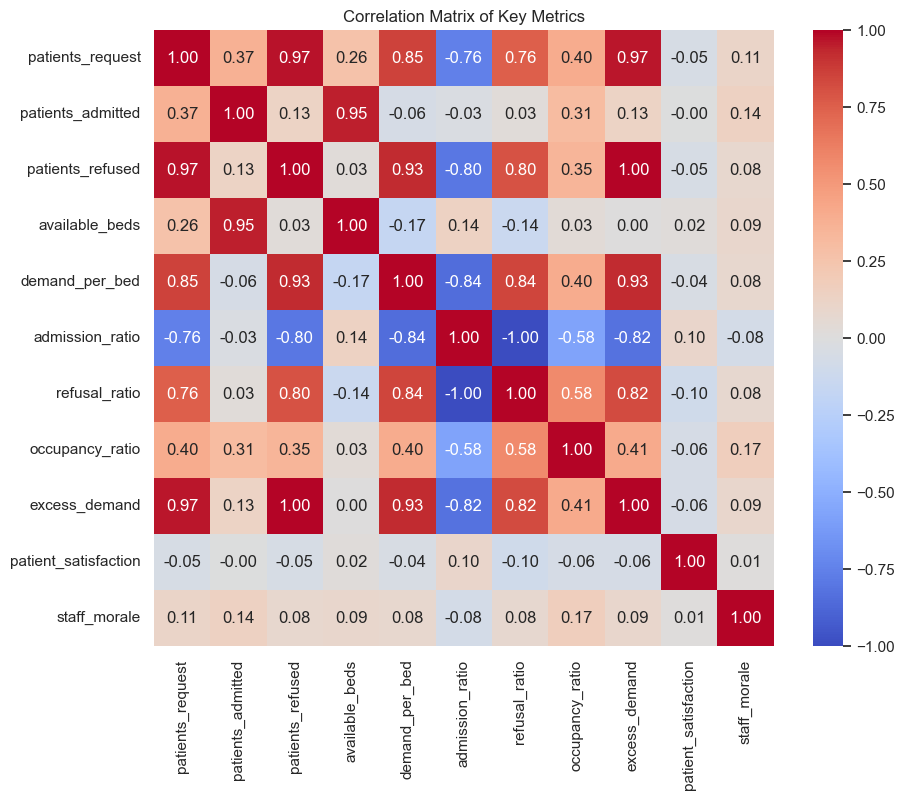

In [9]:
plt.figure(figsize=(10,8))
corr = df[metrics].corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Correlation Matrix of Key Metrics")
plt.show()


In [10]:
if 'service' in df.columns:
    service_group = df.groupby('service')[metrics].agg(['mean','median','std','min','max'])
    display(service_group)


C:\Users\Alejandro\AppData\Local\Temp\ipykernel_4324\2424311028.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  service_group = df.groupby('service')[metrics].agg(['mean','median','std','min','max'])


patients_request                             \
                             mean median        std min  max   
service                                                        
ICU                     15.173077   13.5   8.269294   5   47   
emergency              119.096154  100.5  67.672006  31  388   
general_medicine        82.115385   68.0  50.879193  25  285   
surgery                 43.096154   39.0  21.547266  15  130   

                 patients_admitted                            ...  \
                              mean median        std min max  ...   
service                                                       ...   
ICU                      12.461538   12.0   4.608013   5  23  ...   
emergency                22.788462   22.0   5.912222  15  36  ...   
general_medicine         44.846154   43.0  11.712880  25  74  ...   
surgery                  32.423077   31.0   9.890273  15  59  ...   

                 patient_satisfaction                           staff_morale  \
                                 mean median        std min max         mean   
service                                                                        
ICU                         81.615385   83.0  10.322551  61  98    70.980769   
emergency                   77.884615   75.5  11.087272  62  99    73.557692   
general_medicine            81.230769   81.5  10.955553  60  99    73.096154   
surgery                     79.269231   81.0  11.982201  61  99    72.634615   

                                            
                 median        std min max  
service                                     
ICU                71.5  15.394792  50  98  
emergency          75.0  14.432281  43  99  
general_medicine   71.5  15.527660  40  98  
surgery            74.5  16.720340  31  99  

[4 rows x 55 columns]

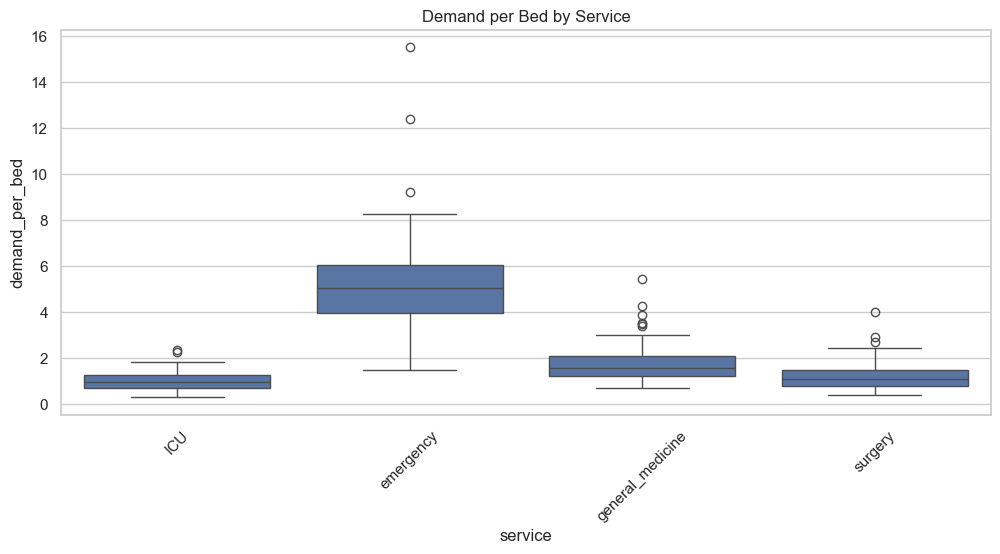

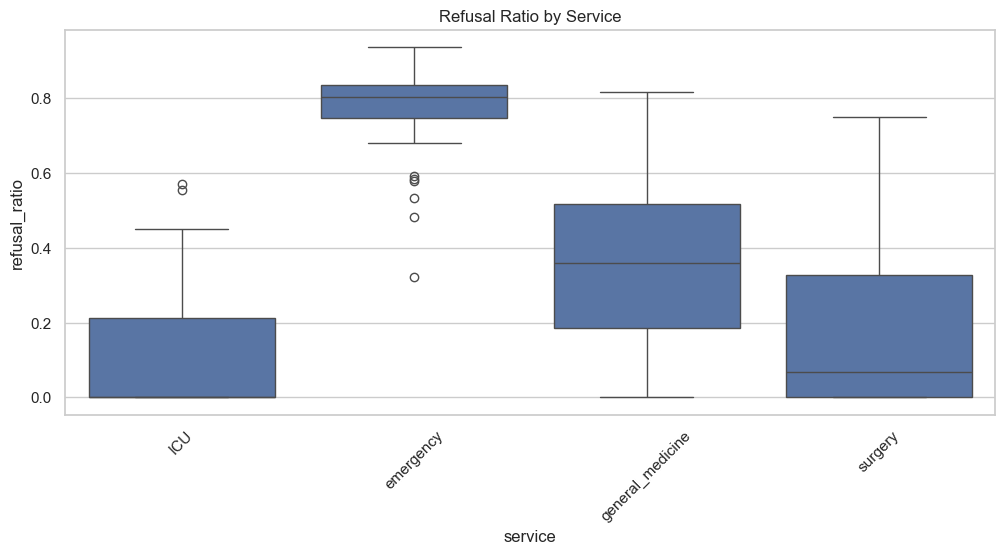

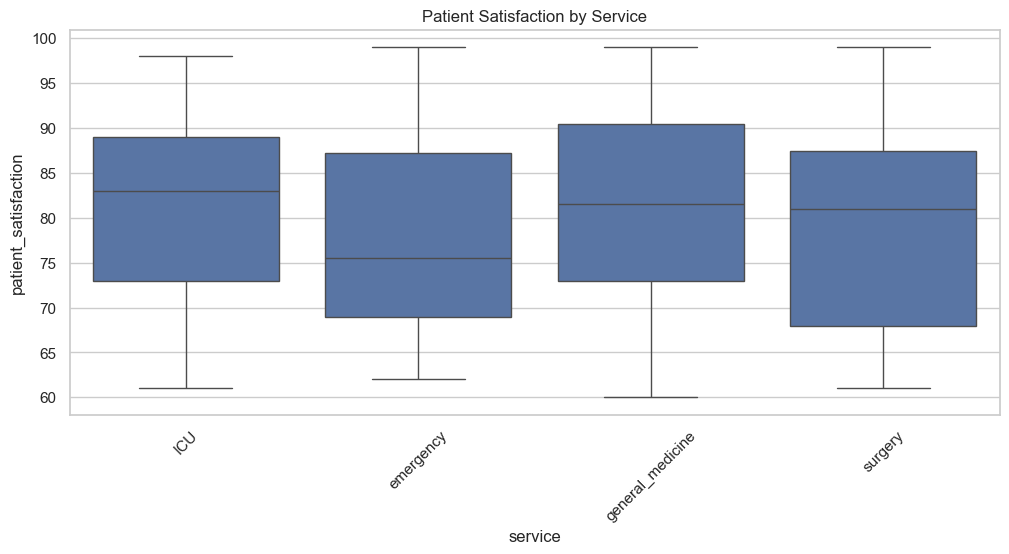

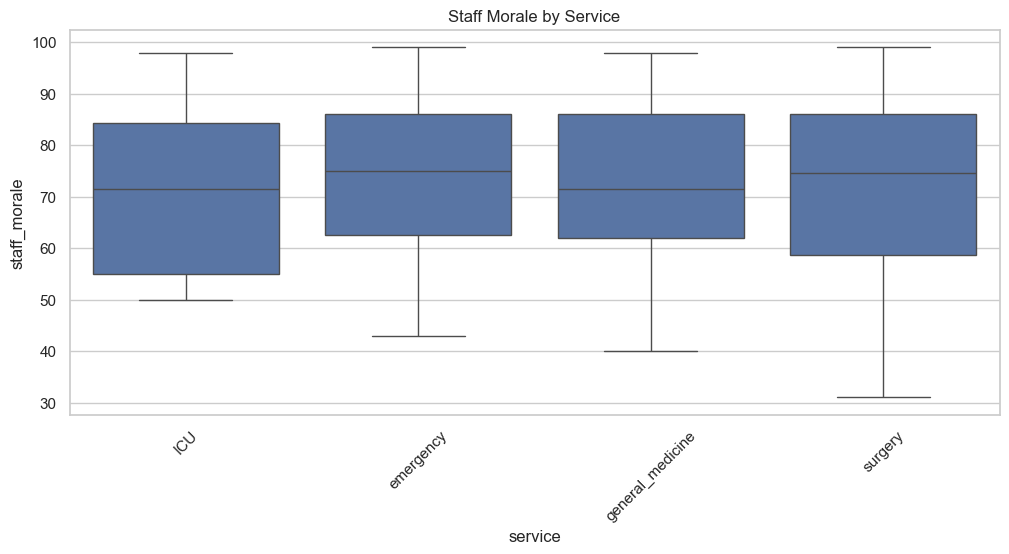

In [11]:
if 'service' in df.columns:
    plt.figure(figsize=(12,5))
    sns.boxplot(data=df, x='service', y='demand_per_bed')
    plt.title("Demand per Bed by Service")
    plt.xticks(rotation=45)
    plt.show()

    plt.figure(figsize=(12,5))
    sns.boxplot(data=df, x='service', y='refusal_ratio')
    plt.title("Refusal Ratio by Service")
    plt.xticks(rotation=45)
    plt.show()

    plt.figure(figsize=(12,5))
    sns.boxplot(data=df, x='service', y='patient_satisfaction')
    plt.title("Patient Satisfaction by Service")
    plt.xticks(rotation=45)
    plt.show()

    plt.figure(figsize=(12,5))
    sns.boxplot(data=df, x='service', y='staff_morale')
    plt.title("Staff Morale by Service")
    plt.xticks(rotation=45)
    plt.show()


In [12]:
if 'service' in df.columns:
    services = df['service'].cat.categories
    service_corrs = {}

    for s in services:
        sub = df[df['service'] == s]
        c = sub[metrics].corr()
        service_corrs[s] = c
        print(f"\nCorrelation matrix for service = {s}")
        display(c)



Correlation matrix for service = ICU


,patients_request,patients_admitted,patients_refused,available_beds,demand_per_bed,admission_ratio,refusal_ratio,occupancy_ratio,excess_demand,patient_satisfaction,staff_morale
patients_request,1.000000,0.825297,0.864049,0.519895,0.809107,-0.733302,0.733302,0.600548,0.862261,-0.076616,0.189938
patients_admitted,0.825297,1.000000,0.428824,0.745349,0.485910,-0.330855,0.330855,0.585766,0.524102,-0.083586,0.347566
patients_refused,0.864049,0.428824,1.000000,0.167262,0.861215,-0.878170,0.878170,0.438551,0.912203,-0.048055,-0.005985
available_beds,0.519895,0.745349,0.167262,1.000000,-0.037134,0.063324,-0.063324,-0.084187,0.015648,-0.146514,0.300079
demand_per_bed,0.809107,0.485910,0.861215,-0.037134,1.000000,-0.945659,0.945659,0.801418,0.969077,0.055860,0.025791
admission_ratio,-0.733302,-0.330855,-0.878170,0.063324,-0.945659,1.000000,-1.000000,-0.615423,-0.895875,-0.110634,0.045260
refusal_ratio,0.733302,0.330855,0.878170,-0.063324,0.945659,-1.000000,1.000000,0.615423,0.895875,0.110634,-0.045260
occupancy_ratio,0.600548,0.585766,0.438551,-0.084187,0.801418,-0.615423,0.615423,1.000000,0.752857,0.059817,0.143065
excess_demand,0.862261,0.524102,0.912203,0.015648,0.969077,-0.895875,0.895875,0.752857,1.000000,-0.002813,0.044409
patient_satisfaction,-0.076616,-0.083586,-0.048055,-0.146514,0.055860,-0.110634,0.110634,0.059817,-0.002813,1.000000,0.037956



Correlation matrix for service = emergency


,patients_request,patients_admitted,patients_refused,available_beds,demand_per_bed,admission_ratio,refusal_ratio,occupancy_ratio,excess_demand,patient_satisfaction,staff_morale
patients_request,1.000000,0.458427,0.996745,0.458427,0.884637,-0.650089,0.650089,NaN,0.996745,0.034171,0.185309
patients_admitted,0.458427,1.000000,0.385284,1.000000,0.015479,0.023955,-0.023955,NaN,0.385284,-0.314761,0.107806
patients_refused,0.996745,0.385284,1.000000,0.385284,0.917141,-0.677180,0.677180,NaN,1.000000,0.064035,0.182633
available_beds,0.458427,1.000000,0.385284,1.000000,0.015479,0.023955,-0.023955,NaN,0.385284,-0.314761,0.107806
demand_per_bed,0.884637,0.015479,0.917141,0.015479,1.000000,-0.778570,0.778570,NaN,0.917141,0.196190,0.157253
admission_ratio,-0.650089,0.023955,-0.677180,0.023955,-0.778570,1.000000,-1.000000,NaN,-0.677180,-0.164465,-0.216854
refusal_ratio,0.650089,-0.023955,0.677180,-0.023955,0.778570,-1.000000,1.000000,NaN,0.677180,0.164465,0.216854
occupancy_ratio,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
excess_demand,0.996745,0.385284,1.000000,0.385284,0.917141,-0.677180,0.677180,NaN,1.000000,0.064035,0.182633
patient_satisfaction,0.034171,-0.314761,0.064035,-0.314761,0.196190,-0.164465,0.164465,NaN,0.064035,1.000000,0.041583



Correlation matrix for service = general_medicine


,patients_request,patients_admitted,patients_refused,available_beds,demand_per_bed,admission_ratio,refusal_ratio,occupancy_ratio,excess_demand,patient_satisfaction,staff_morale
patients_request,1.000000,0.475830,0.975109,0.370736,0.857850,-0.748275,0.748275,0.319228,0.971038,0.039420,-0.028283
patients_admitted,0.475830,1.000000,0.268970,0.958248,0.031111,0.021118,-0.021118,0.104214,0.260913,0.082184,0.222064
patients_refused,0.975109,0.268970,1.000000,0.164411,0.931556,-0.824732,0.824732,0.323303,0.997573,0.022449,-0.086953
available_beds,0.370736,0.958248,0.164411,1.000000,-0.087927,0.188356,-0.188356,-0.174387,0.138098,0.129519,0.182702
demand_per_bed,0.857850,0.031111,0.931556,-0.087927,1.000000,-0.903913,0.903913,0.414992,0.937442,-0.033465,-0.138673
admission_ratio,-0.748275,0.021118,-0.824732,0.188356,-0.903913,1.000000,-1.000000,-0.589415,-0.846427,0.174224,0.074723
refusal_ratio,0.748275,-0.021118,0.824732,-0.188356,0.903913,-1.000000,1.000000,0.589415,0.846427,-0.174224,-0.074723
occupancy_ratio,0.319228,0.104214,0.323303,-0.174387,0.414992,-0.589415,0.589415,1.000000,0.385292,-0.192615,0.115677
excess_demand,0.971038,0.260913,0.997573,0.138098,0.937442,-0.846427,0.846427,0.385292,1.000000,0.008717,-0.077163
patient_satisfaction,0.039420,0.082184,0.022449,0.129519,-0.033465,0.174224,-0.174224,-0.192615,0.008717,1.000000,-0.042780



Correlation matrix for service = surgery


,patients_request,patients_admitted,patients_refused,available_beds,demand_per_bed,admission_ratio,refusal_ratio,occupancy_ratio,excess_demand,patient_satisfaction,staff_morale
patients_request,1.000000,0.473559,0.888467,0.120411,0.827660,-0.713094,0.713094,0.504567,0.882251,-0.046277,0.215783
patients_admitted,0.473559,1.000000,0.016523,0.748972,-0.005704,0.128903,-0.128903,0.322493,0.089653,0.076123,0.180706
patients_refused,0.888467,0.016523,1.000000,-0.253575,0.942552,-0.876691,0.876691,0.404755,0.954837,-0.092200,0.150801
available_beds,0.120411,0.748972,-0.253575,1.000000,-0.415159,0.501129,-0.501129,-0.371881,-0.361122,0.131136,-0.005189
demand_per_bed,0.827660,-0.005704,0.942552,-0.415159,1.000000,-0.945972,0.945972,0.617242,0.974346,-0.112943,0.215157
admission_ratio,-0.713094,0.128903,-0.876691,0.501129,-0.945972,1.000000,-1.000000,-0.578553,-0.907498,0.063158,-0.215751
refusal_ratio,0.713094,-0.128903,0.876691,-0.501129,0.945972,-1.000000,1.000000,0.578553,0.907498,-0.063158,0.215751
occupancy_ratio,0.504567,0.322493,0.404755,-0.371881,0.617242,-0.578553,0.578553,1.000000,0.650324,-0.087287,0.263764
excess_demand,0.882251,0.089653,0.954837,-0.361122,0.974346,-0.907498,0.907498,0.650324,1.000000,-0.105659,0.205157
patient_satisfaction,-0.046277,0.076123,-0.092200,0.131136,-0.112943,0.063158,-0.063158,-0.087287,-0.105659,1.000000,0.022423


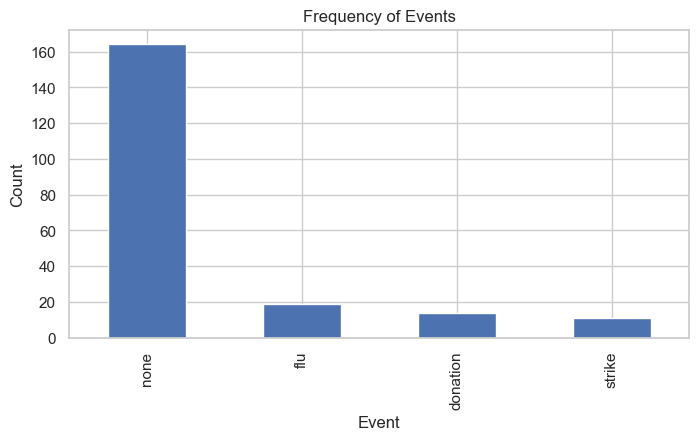

In [13]:
if 'event' in df.columns:
    plt.figure(figsize=(8,4))
    df['event'].value_counts().plot(kind='bar')
    plt.title("Frequency of Events")
    plt.xlabel("Event")
    plt.ylabel("Count")
    plt.show()


C:\Users\Alejandro\AppData\Local\Temp\ipykernel_4324\1190621163.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  event_group = df.groupby('event')[metrics].agg(['mean','median','std'])


patients_request                    patients_admitted         \
                     mean median         std              mean median   
event                                                                   
donation        54.714286   56.0   29.761691         25.571429   26.5   
flu            161.263158  177.0  107.665037         35.105263   31.0   
none            56.201220   48.0   42.260248         27.823171   26.0   
strike          40.545455   29.0   24.707746         23.909091   21.0   

                    patients_refused                    available_beds  ...  \
                std             mean median         std           mean  ...   
event                                                                   ...   
donation  13.345782        29.142857   22.0   29.529274      28.357143  ...   
flu       15.491556       126.157895  126.0  102.191141      35.105263  ...   
none      14.838573        28.378049    9.0   39.335942      29.829268  ...   
strike     9.148274        16.636364    0.0   25.247862      32.363636  ...   

         occupancy_ratio excess_demand                     \
                     std          mean median         std   
event                                                       
donation        0.173722     26.357143   22.0   32.792136   
flu             0.000000    126.157895  126.0  102.191141   
none            0.137969     26.371951    9.0   40.969861   
strike          0.235250      8.181818   -6.0   32.430906   

         patient_satisfaction                   staff_morale                    
                         mean median        std         mean median        std  
event                                                                           
donation            82.714286   82.0  10.665751    80.142857   82.0  11.601440  
flu                 78.736842   73.0  11.850186    72.894737   76.0  14.925350  
none                79.725610   80.5  11.014394    73.146341   73.0  15.137101  
strike              82.818182   82.0  12.679260    53.727273   58.0  12.602309  

[4 rows x 33 columns]

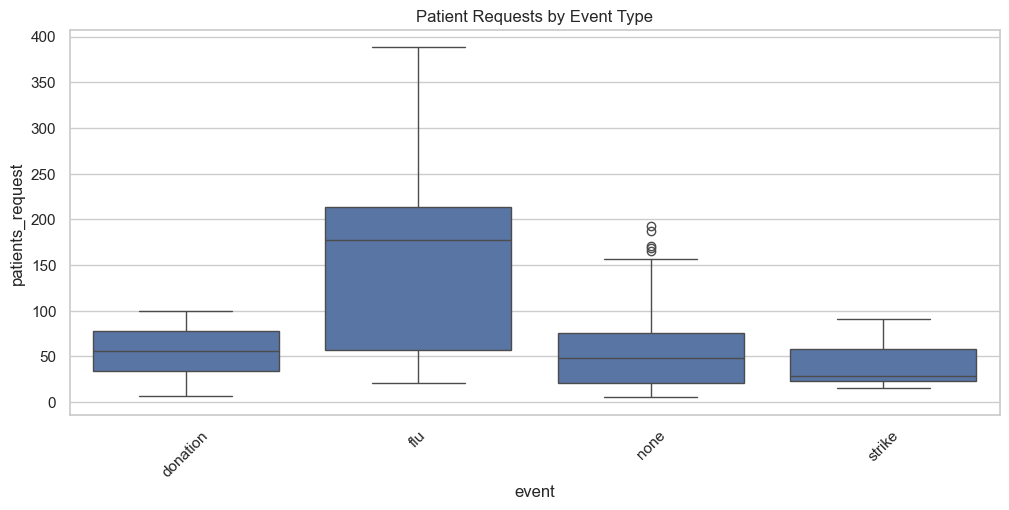

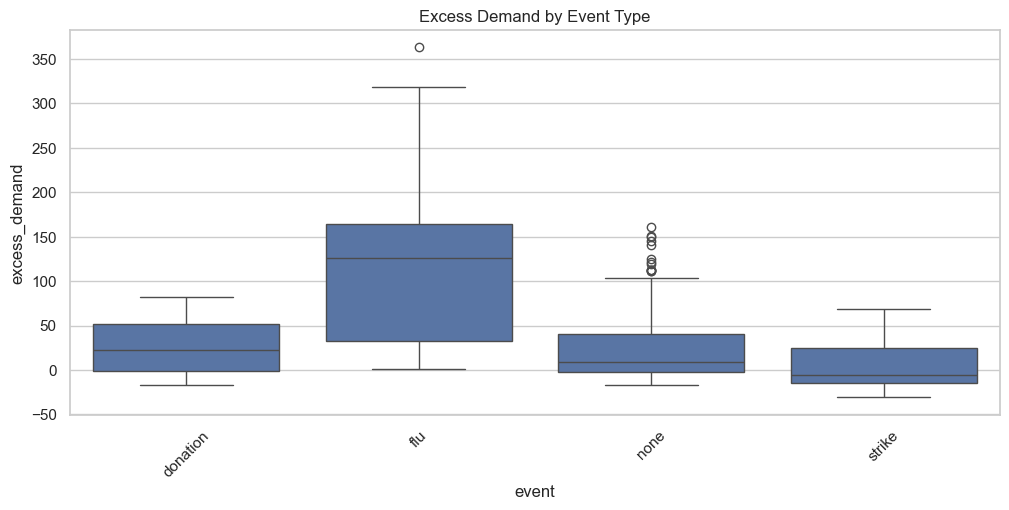

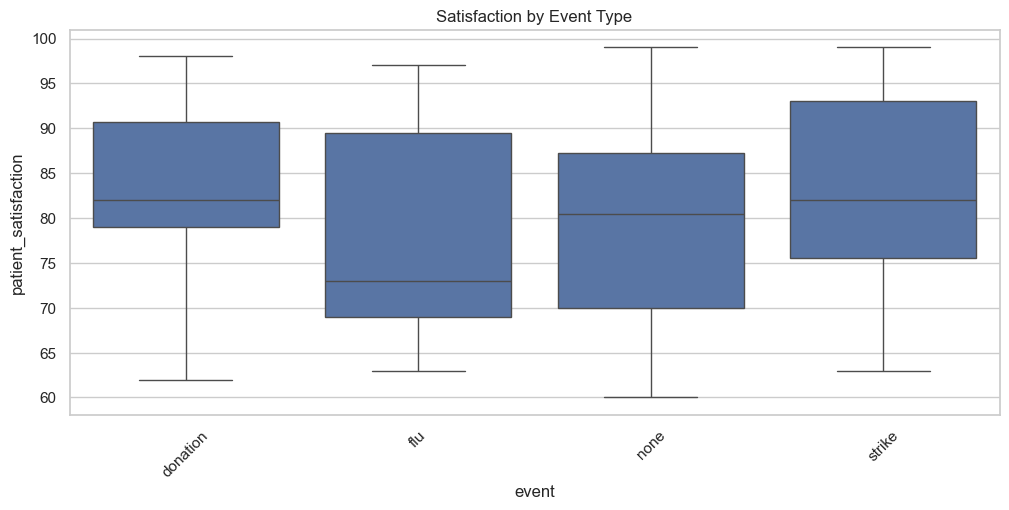

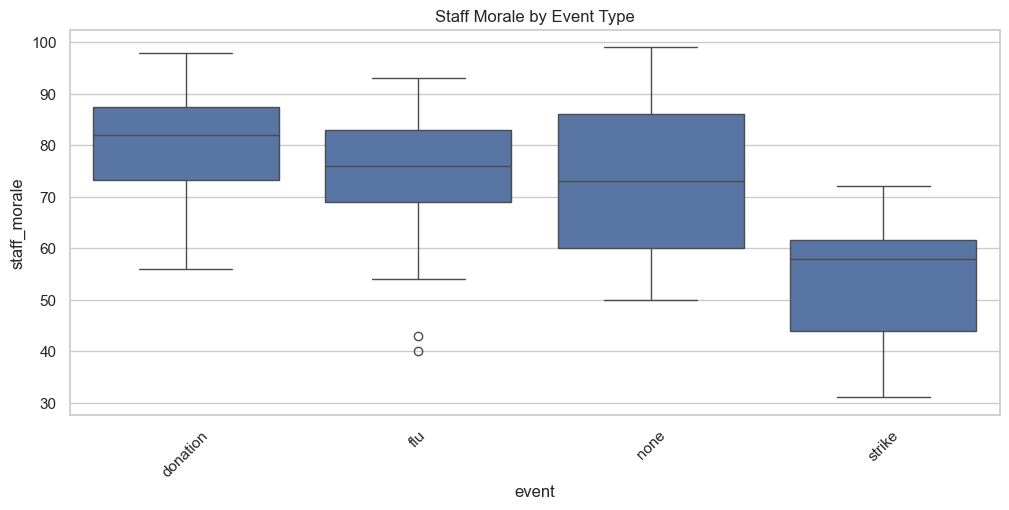

In [14]:
if 'event' in df.columns:
    event_group = df.groupby('event')[metrics].agg(['mean','median','std'])
    display(event_group)

    plt.figure(figsize=(12,5))
    sns.boxplot(data=df, x='event', y='patients_request')
    plt.title("Patient Requests by Event Type")
    plt.xticks(rotation=45)
    plt.show()

    plt.figure(figsize=(12,5))
    sns.boxplot(data=df, x='event', y='excess_demand')
    plt.title("Excess Demand by Event Type")
    plt.xticks(rotation=45)
    plt.show()

    plt.figure(figsize=(12,5))
    sns.boxplot(data=df, x='event', y='patient_satisfaction')
    plt.title("Satisfaction by Event Type")
    plt.xticks(rotation=45)
    plt.show()

    plt.figure(figsize=(12,5))
    sns.boxplot(data=df, x='event', y='staff_morale')
    plt.title("Staff Morale by Event Type")
    plt.xticks(rotation=45)
    plt.show()


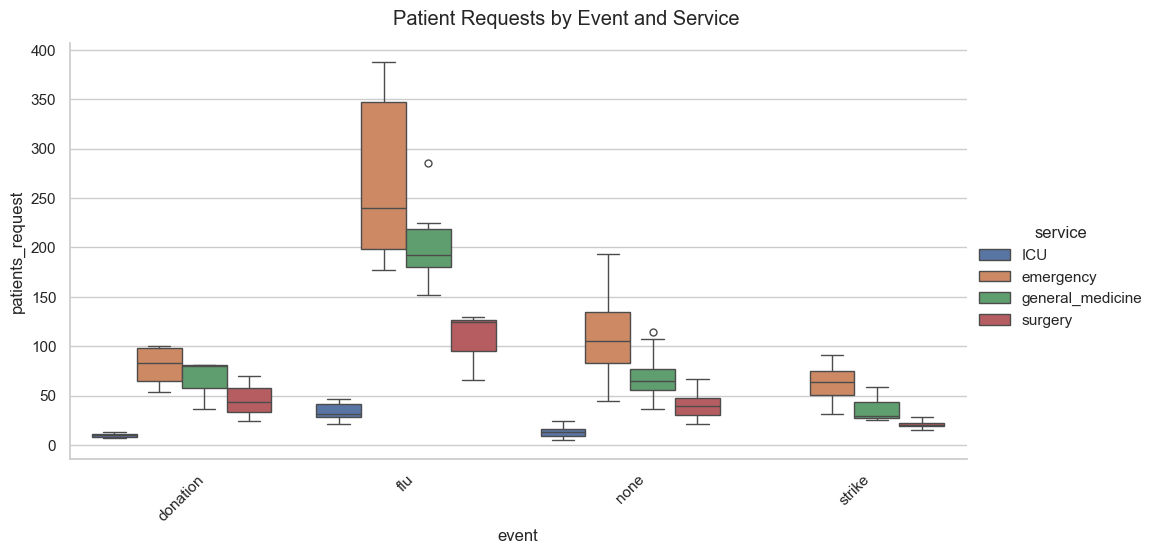

In [15]:
if 'event' in df.columns and 'service' in df.columns:
    g = sns.catplot(
        data=df,
        x='event', y='patients_request', hue='service',
        kind='box', height=5, aspect=2
    )
    g.fig.suptitle("Patient Requests by Event and Service", y=1.03)
    plt.xticks(rotation=45)
    plt.show()


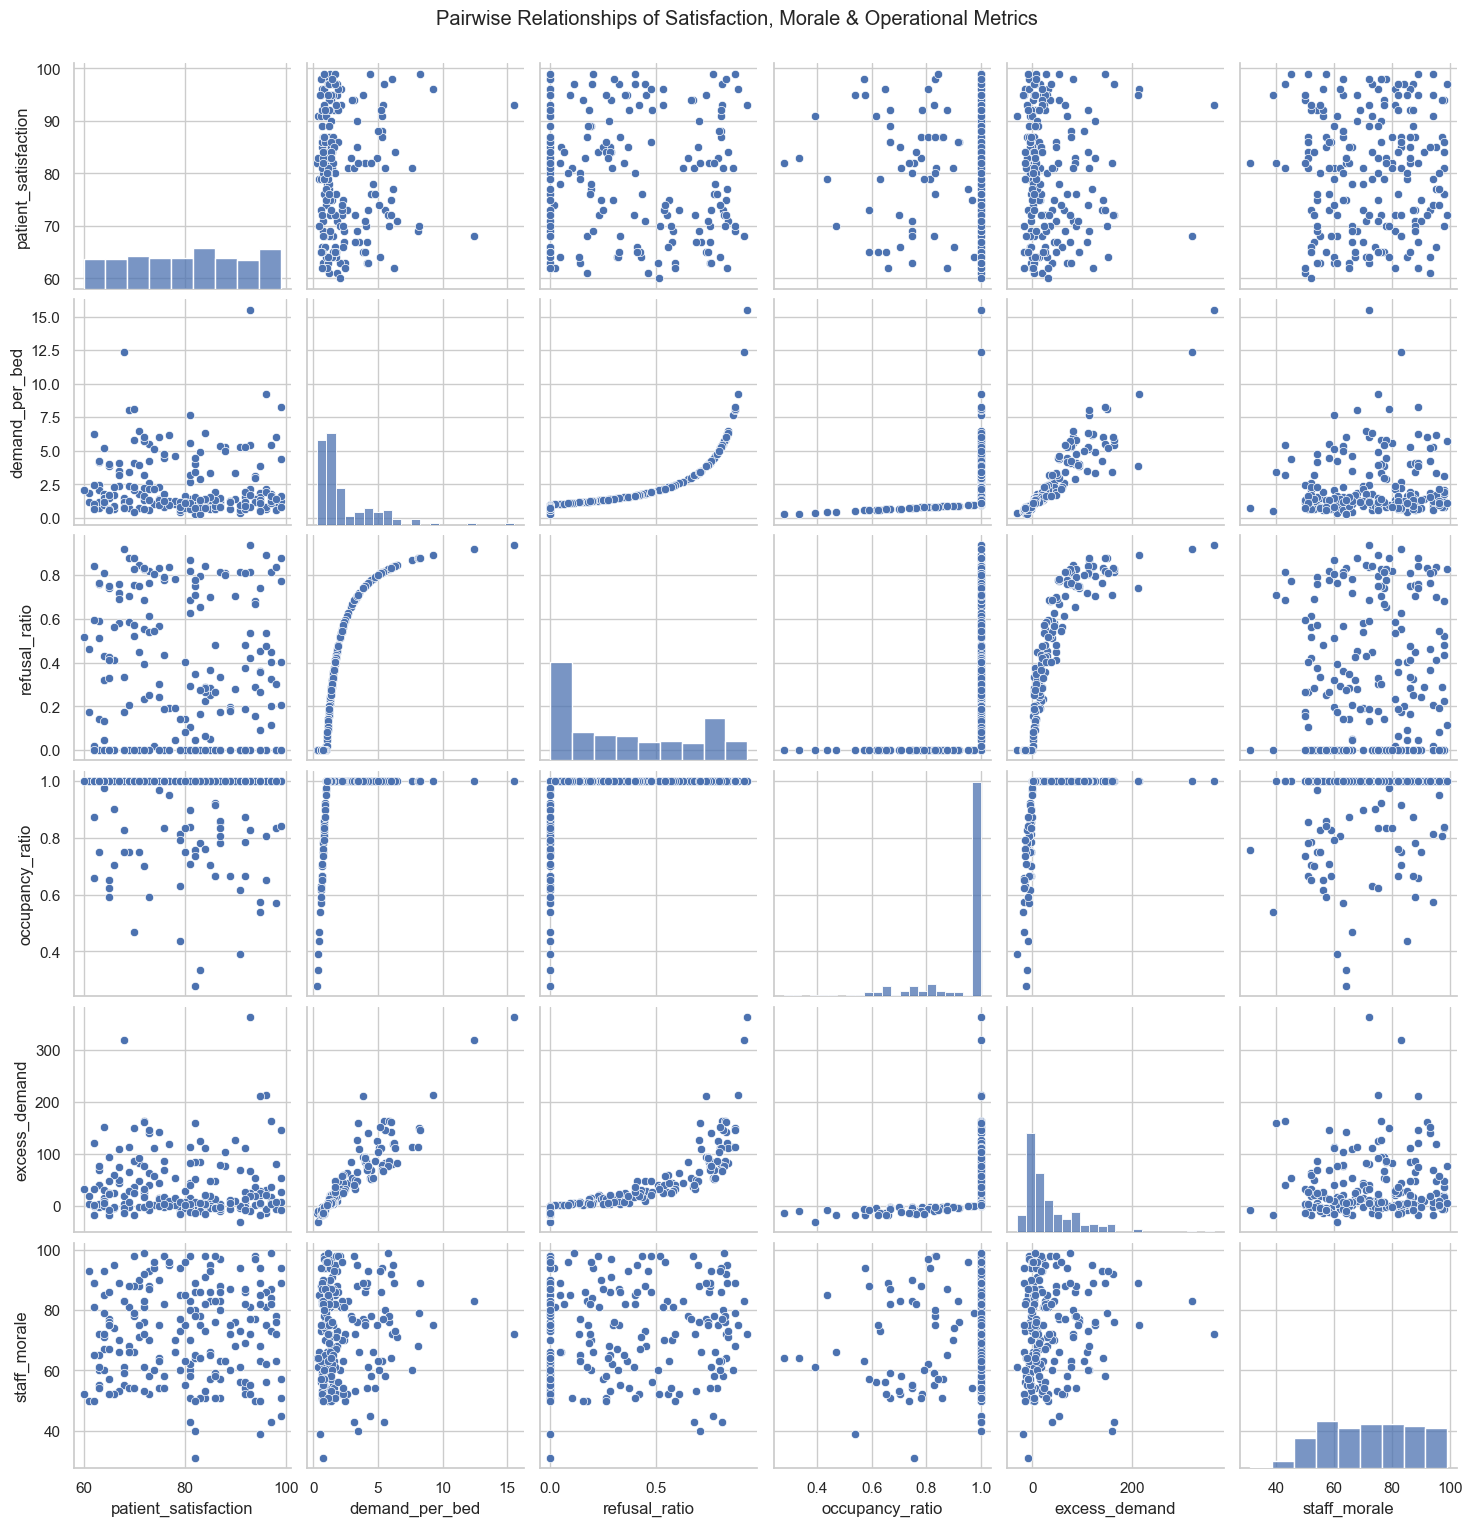

In [16]:
rel_cols = [
    'patient_satisfaction',
    'demand_per_bed',
    'refusal_ratio',
    'occupancy_ratio',
    'excess_demand',
    'staff_morale'
]

sns.pairplot(df[rel_cols].dropna())
plt.suptitle("Pairwise Relationships of Satisfaction, Morale & Operational Metrics", y=1.02)
plt.show()


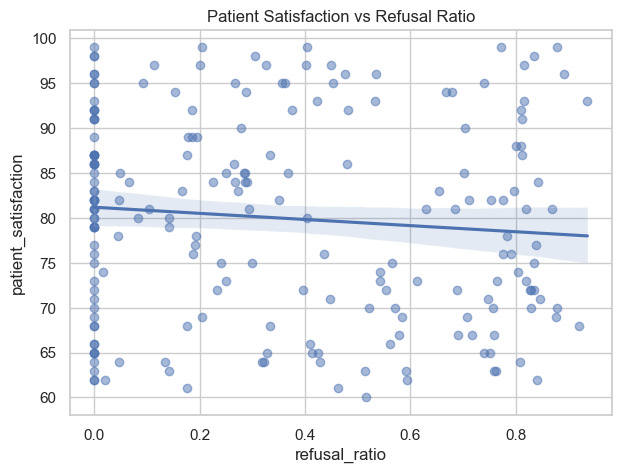

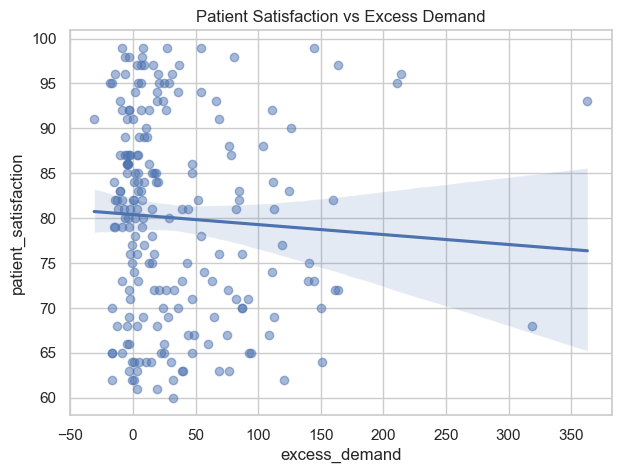

In [17]:
plt.figure(figsize=(7,5))
sns.regplot(data=df, x='refusal_ratio', y='patient_satisfaction', scatter_kws={'alpha':0.5})
plt.title("Patient Satisfaction vs Refusal Ratio")
plt.show()

plt.figure(figsize=(7,5))
sns.regplot(data=df, x='excess_demand', y='patient_satisfaction', scatter_kws={'alpha':0.5})
plt.title("Patient Satisfaction vs Excess Demand")
plt.show()


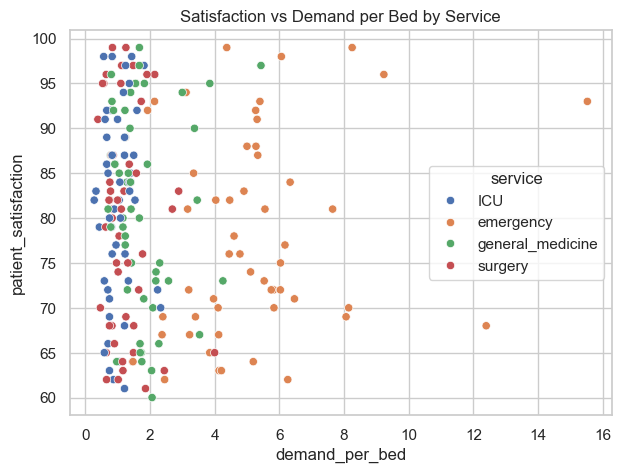

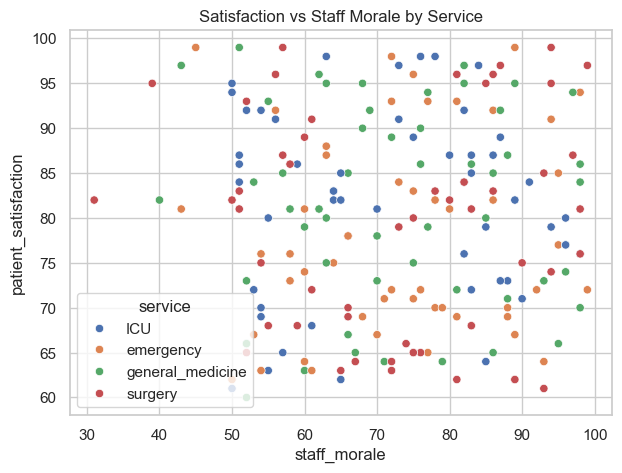

In [18]:
if 'service' in df.columns:
    plt.figure(figsize=(7,5))
    sns.scatterplot(
        data=df,
        x='demand_per_bed',
        y='patient_satisfaction',
        hue='service'
    )
    plt.title("Satisfaction vs Demand per Bed by Service")
    plt.show()

    plt.figure(figsize=(7,5))
    sns.scatterplot(
        data=df,
        x='staff_morale',
        y='patient_satisfaction',
        hue='service'
    )
    plt.title("Satisfaction vs Staff Morale by Service")
    plt.show()


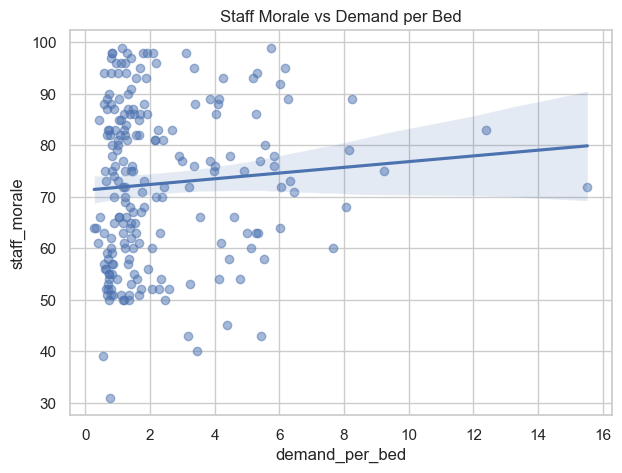

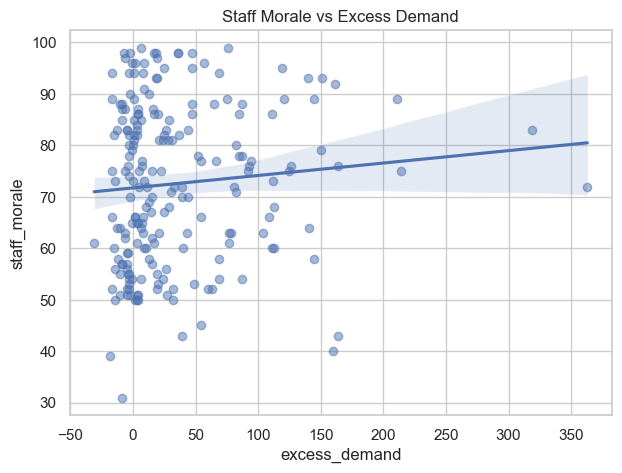

In [19]:
plt.figure(figsize=(7,5))
sns.regplot(data=df, x='demand_per_bed', y='staff_morale', scatter_kws={'alpha':0.5})
plt.title("Staff Morale vs Demand per Bed")
plt.show()

plt.figure(figsize=(7,5))
sns.regplot(data=df, x='excess_demand', y='staff_morale', scatter_kws={'alpha':0.5})
plt.title("Staff Morale vs Excess Demand")
plt.show()


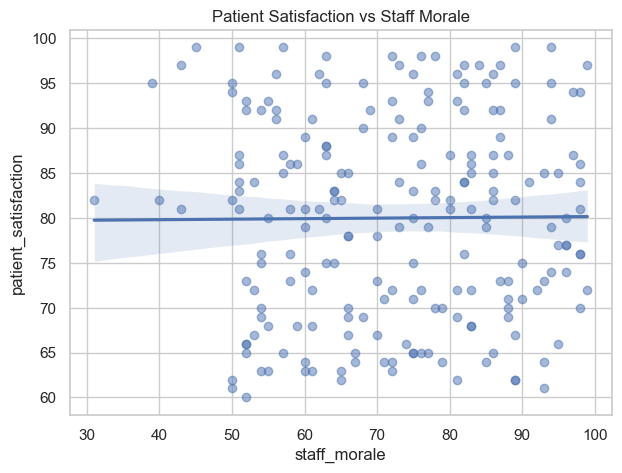

In [20]:
plt.figure(figsize=(7,5))
sns.regplot(data=df, x='staff_morale', y='patient_satisfaction', scatter_kws={'alpha':0.5})
plt.title("Patient Satisfaction vs Staff Morale")
plt.show()


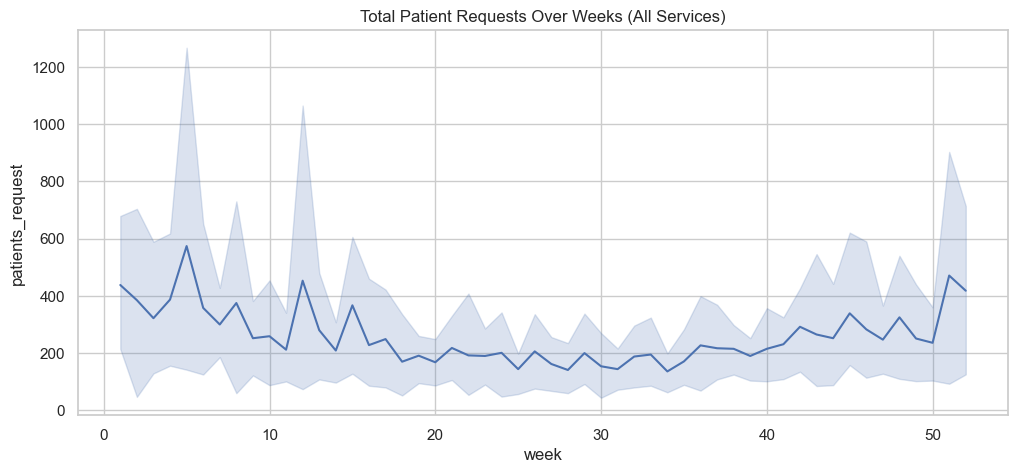

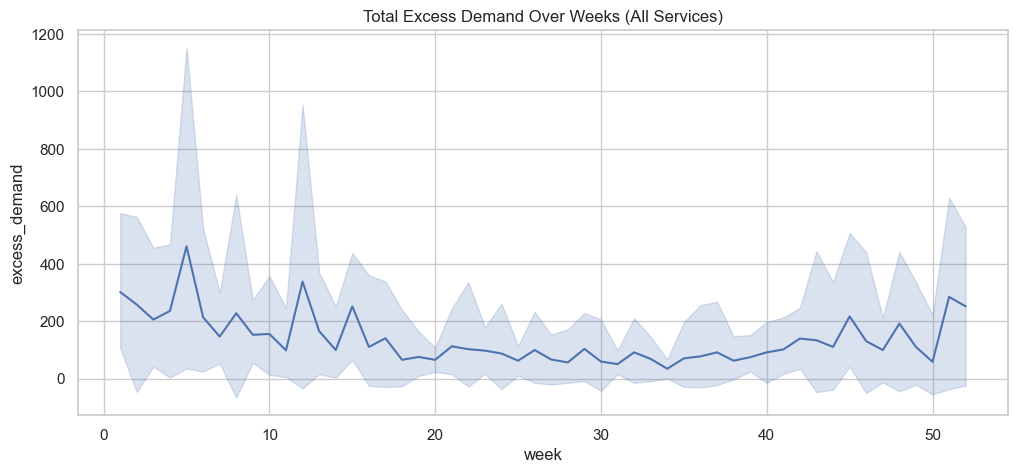

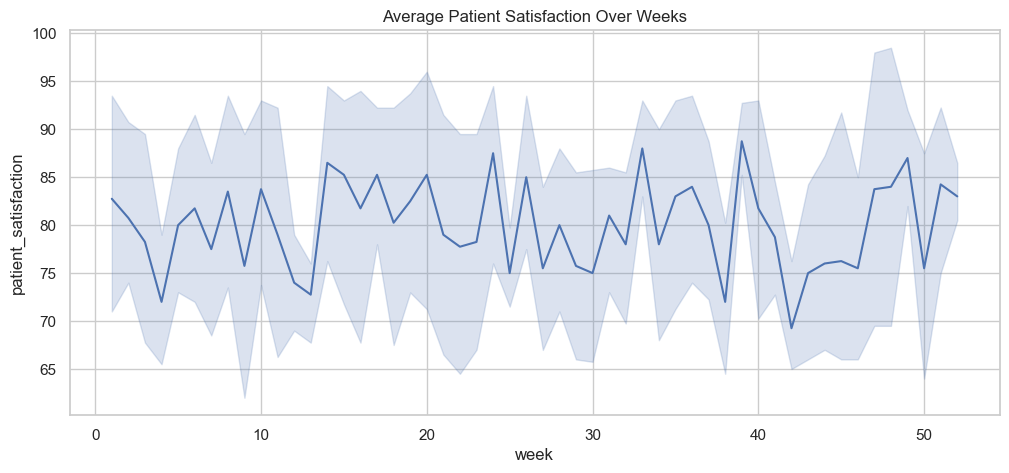

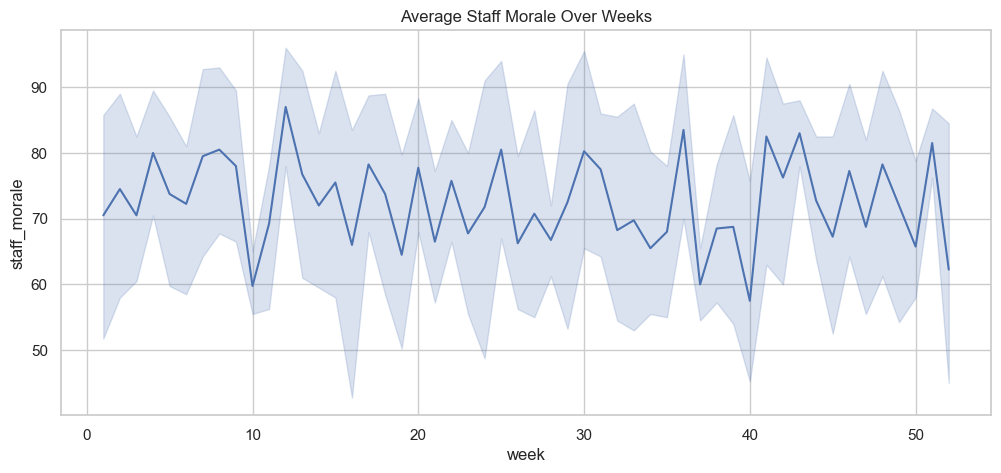

In [21]:
plt.figure(figsize=(12,5))
sns.lineplot(data=df, x='week', y='patients_request', estimator='sum')
plt.title("Total Patient Requests Over Weeks (All Services)")
plt.show()

plt.figure(figsize=(12,5))
sns.lineplot(data=df, x='week', y='excess_demand', estimator='sum')
plt.title("Total Excess Demand Over Weeks (All Services)")
plt.show()

plt.figure(figsize=(12,5))
sns.lineplot(data=df, x='week', y='patient_satisfaction')
plt.title("Average Patient Satisfaction Over Weeks")
plt.show()

plt.figure(figsize=(12,5))
sns.lineplot(data=df, x='week', y='staff_morale')
plt.title("Average Staff Morale Over Weeks")
plt.show()


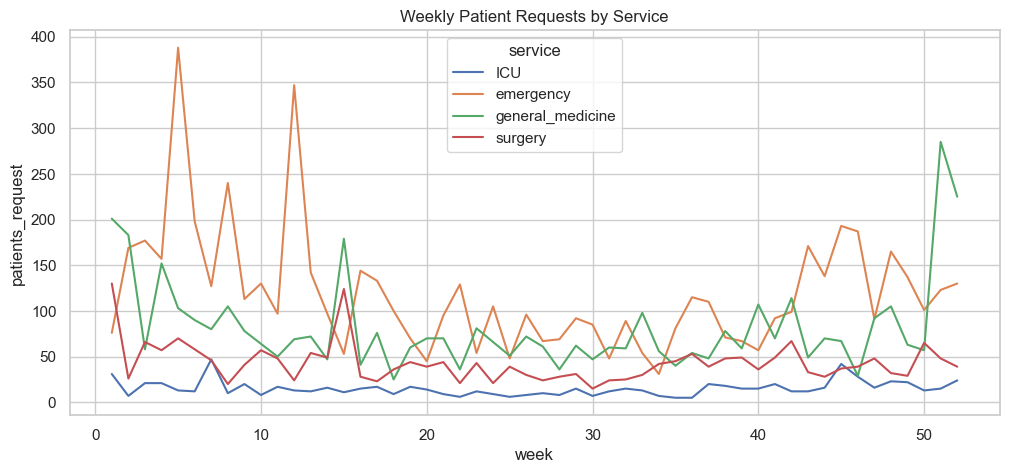

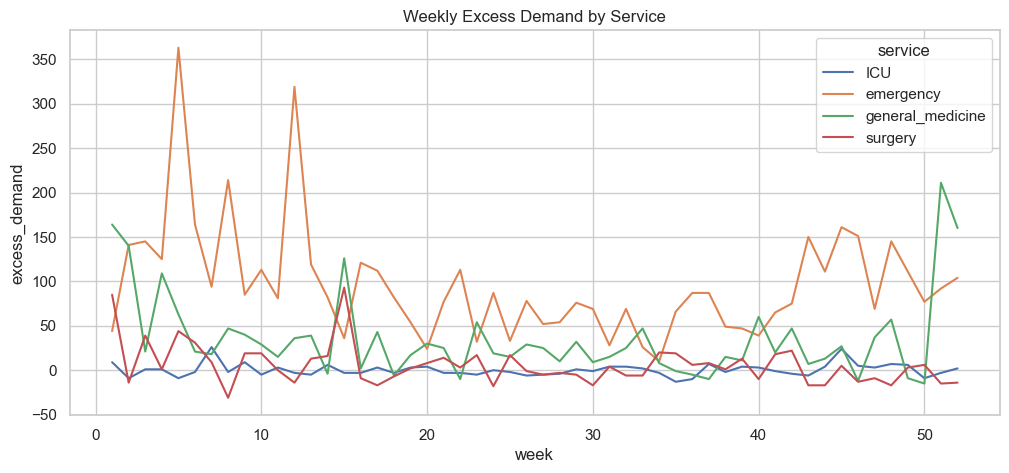

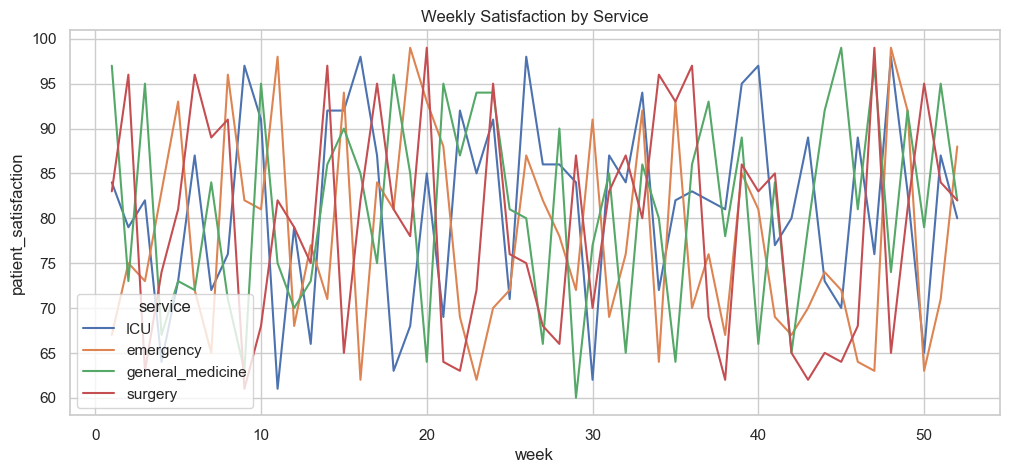

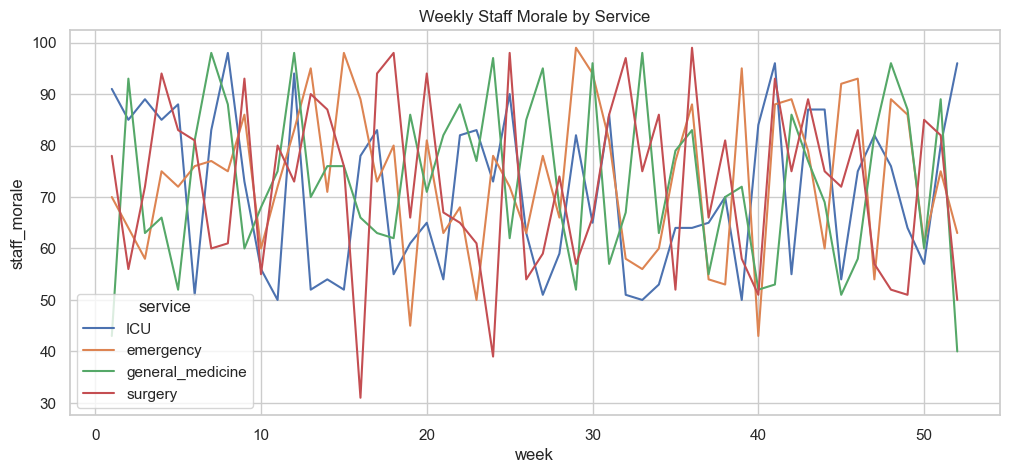

In [22]:
if 'service' in df.columns:
    plt.figure(figsize=(12,5))
    sns.lineplot(data=df, x='week', y='patients_request', hue='service')
    plt.title("Weekly Patient Requests by Service")
    plt.show()

    plt.figure(figsize=(12,5))
    sns.lineplot(data=df, x='week', y='excess_demand', hue='service')
    plt.title("Weekly Excess Demand by Service")
    plt.show()

    plt.figure(figsize=(12,5))
    sns.lineplot(data=df, x='week', y='patient_satisfaction', hue='service')
    plt.title("Weekly Satisfaction by Service")
    plt.show()

    plt.figure(figsize=(12,5))
    sns.lineplot(data=df, x='week', y='staff_morale', hue='service')
    plt.title("Weekly Staff Morale by Service")
    plt.show()


C:\Users\Alejandro\AppData\Local\Temp\ipykernel_4324\241509271.py:2: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_dem = df.pivot_table(


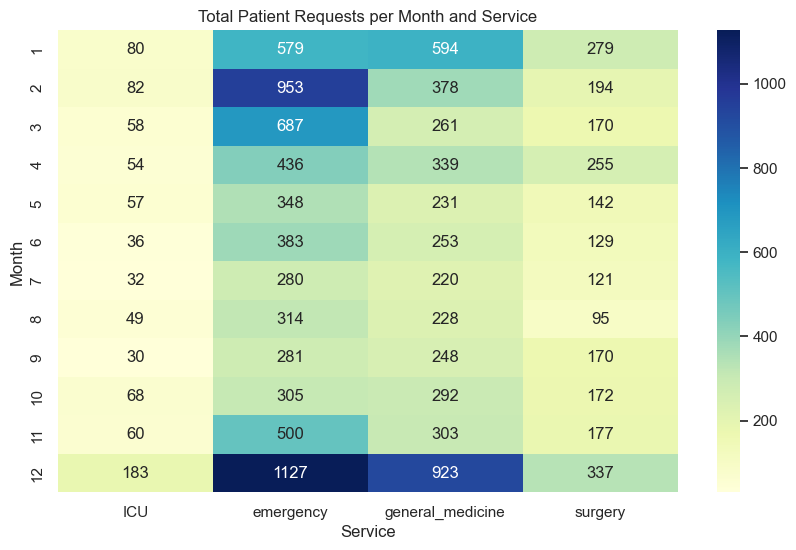

In [23]:
if 'service' in df.columns:
    pivot_dem = df.pivot_table(
        index='month', columns='service', values='patients_request', aggfunc='sum'
    )

    plt.figure(figsize=(10,6))
    sns.heatmap(pivot_dem, annot=True, fmt=".0f", cmap="YlGnBu")
    plt.title("Total Patient Requests per Month and Service")
    plt.ylabel("Month")
    plt.xlabel("Service")
    plt.show()


In [24]:
# Select rows with all needed numeric features
cluster_features = [
    'patients_request', 'patients_admitted', 'patients_refused',
    'available_beds', 'demand_per_bed', 'admission_ratio',
    'refusal_ratio', 'occupancy_ratio', 'excess_demand',
    'patient_satisfaction', 'staff_morale'
]

cluster_df = df[cluster_features].dropna()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(cluster_df)

# Try a small number of clusters, e.g., 3 or 4
k = 3
kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
cluster_labels = kmeans.fit_predict(X_scaled)

# Attach cluster labels back
df.loc[cluster_df.index, 'cluster'] = cluster_labels

df['cluster'] = df['cluster'].astype('category')

print("\nCluster sizes:")
print(df['cluster'].value_counts())
display(df[['week','month','service','event','cluster']].head())


c:\Users\Alejandro\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(



Cluster sizes:
cluster
0.0    81
2.0    72
1.0    55
Name: count, dtype: int64


,week,month,service,event,cluster
0,1,1,emergency,none,0.0
1,1,1,surgery,flu,1.0
2,1,1,general_medicine,flu,1.0
3,1,1,ICU,flu,0.0
4,2,1,emergency,none,1.0


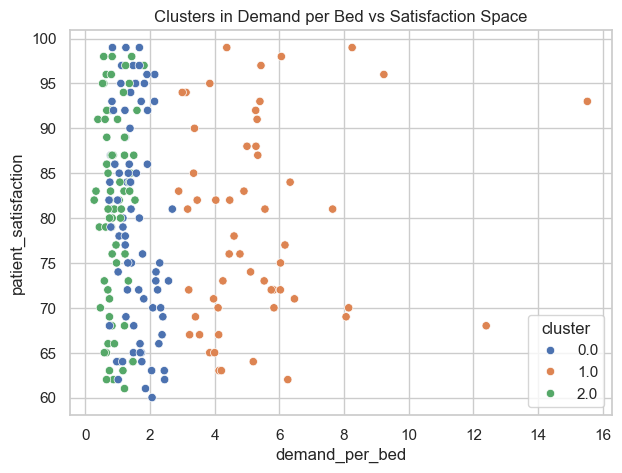

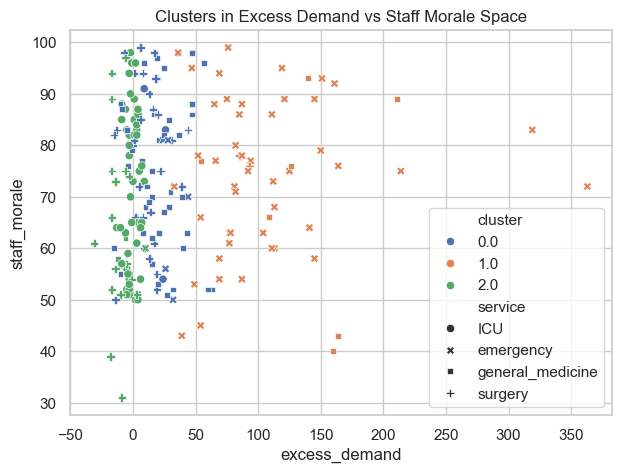

In [25]:
plt.figure(figsize=(7,5))
sns.scatterplot(
    data=df.dropna(subset=['demand_per_bed','patient_satisfaction','cluster']),
    x='demand_per_bed',
    y='patient_satisfaction',
    hue='cluster'
)
plt.title("Clusters in Demand per Bed vs Satisfaction Space")
plt.show()

if 'service' in df.columns:
    plt.figure(figsize=(7,5))
    sns.scatterplot(
        data=df.dropna(subset=['excess_demand','staff_morale','cluster']),
        x='excess_demand',
        y='staff_morale',
        hue='cluster',
        style='service'
    )
    plt.title("Clusters in Excess Demand vs Staff Morale Space")
    plt.show()


In [26]:
import sklearn
print(sklearn.__version__)


1.4.2
